In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

In [132]:
# Options
pd.set_option('max_colwidth', 500)

In [133]:
df = pd.read_csv('./data/transactions.csv', low_memory=False)

df.head()

,block_time,block_number,hash,value,tx_fee,nonce,from,to,method_id,sender,receiver,project,token_bought_symbol,token_sold_symbol,token_bought_amount,token_sold_amount,amount_usd,taker,tx_from,tx_to
0,2023-04-14 14:51:35.000 UTC,17046105.0,0x2afae7763487e60b893cb57803694810e6d3d136186a6de6719921afd7ca304a,0,0.037013,0.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,NaN,0x60806040,0x0000000000000000000000000000000000000000,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-14 16:20:47.000 UTC,17046538.0,0xb38bba8bf8f61029a31e027c37fbc1065db784a39501d456a05cc490db5b4578,0,0.001861,3.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0x6982508145454ce325ddbe47a25d4ec3d2311933,0xa9059cbb,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0x92fb5b4f8030103e0b11275c30965d1897ff23e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-14 17:21:11.000 UTC,17046833.0,0x273894b35d8c30d32e1ffa22ee6aa320cc9f55f2adbba0583594ed47c031f6f6,2000000000000000000,0.077539,4.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf305d719,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-14 17:34:47.000 UTC,17046900.0,0xc3760b499850b19d8f266dc10349d70f69c91698233697cbad2ee90ff957ed17,1000000000000000,0.004451,5.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x3593564c,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,uniswap-2,PEPE,WETH,1.951464e+11,0.001,2.079390,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b
4,2023-04-14 19:46:59.000 UTC,17047545.0,0x08153c0546e4f73b178edae90d1e30fb519c7c49ff0dcd00e4b0bcd74dab468c,13000034453500519,0.009752,12056.0,0xaf2358e98683265cbd3a48509123d390ddf54534,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7ff36ab5,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xaf2358e98683265cbd3a48509123d390ddf54534,uniswap-2,PEPE,WETH,2.519324e+12,0.013,27.131592,0xaf2358e98683265cbd3a48509123d390ddf54534,0xaf2358e98683265cbd3a48509123d390ddf54534,0x7a250d5630b4cf539739df2c5dacb4c659f2488d


In [134]:
# Overview
start_time = df['block_time'].iloc[0]
end_time = df['block_time'].iloc[-1]
start_block = int(df['block_number'].iloc[0])
end_block = int(df['block_number'].iloc[-1])
total_transasctions = df['hash'].unique().size
total_wallet = df['from'].unique().size
total_eth_paid = round(df['tx_fee'].sum(axis=0))
current_eth_price = requests.get('https://min-api.cryptocompare.com/data/price?fsym=ETH&tsyms=USD').json()
total_trading_volume = round(df['amount_usd'].sum(axis=0))

print('Overview:')
print('Time: {} to {}'.format(start_time, end_time))
print('Block: {} to {} ~{} blocks'.format(start_block, end_block, end_block - start_block))
print('Total transasctions: {:,} transactions'.format(total_transasctions))
print('Total unique user: {:,} users'.format(total_wallet))
print('Total fee paid: {:,} ETH ~${:,}'.format(total_eth_paid, round(total_eth_paid * current_eth_price['USD'])))
print('Total trading volume: ${:,}'.format(total_trading_volume))


Overview:
Time: 2023-04-14 14:51:35.000 UTC to 2023-05-05 18:06:23.000 UTC
Block: 17046105 to 17196108 ~150003 blocks
Total transasctions: 539,497 transactions
Total unique user: 129,047 users
Total fee paid: 12,469 ETH ~$22,680,612
Total trading volume: $2,939,838,678


In [135]:
# Wallet with the first swap transaction
minimum_nonce = 0
df = df.drop_duplicates(['hash'])
df_fresh_nonce = df[
  (df['nonce'] <= minimum_nonce)
  & (df['project'].notnull())
  & (df['token_bought_symbol'] == 'PEPE')
]
number_of_fresh_wallet = df_fresh_nonce['from'].unique().size

print('{:,} fresh wallets '.format(number_of_fresh_wallet))
df_fresh_nonce[['block_time', 'hash', 'from', 'amount_usd']] \
  .sort_values(['block_time', 'amount_usd'], ascending=True) \
  .head(10)

19,770 fresh wallets 


,block_time,hash,from,amount_usd
5,2023-04-14 19:47:23.000 UTC,0x3d1d6cfa8493840f9b3c051635d48eaa598c4dbadba4124ede97663440d16450,0xf5c0cdb9e18a4af157fdd369540ec9f4912b5edf,25.439960
6,2023-04-14 19:47:47.000 UTC,0x0091dd9fb3f6a56a5c9ced5f42a5224d07095bf6694ae8b0f55f29af705c7aef,0x8ccf59bc5daafc43ff67f9825f08bbfbabc5cef6,23.552550
7,2023-04-14 19:47:47.000 UTC,0x99bc54643dde75eda471578c1b1d2bc7691a7e485b6ebf0fdcd845426eccd657,0x1298652974068e0d3a7bcdd6e29d6409101833ac,25.883876
8,2023-04-14 19:47:59.000 UTC,0x9db7c486266ae015e5a991318304587494228f5ae1e1447c9c4745be8065d9a7,0xe7a63eb84850f42b5e54a8a24a8cb4fdbf2be1f8,26.220661
9,2023-04-14 19:48:11.000 UTC,0x1ef42241217c0251cf249aac91e2426a8de21943e2e6ff59a6cc03498122d7f9,0x3191203c8a89d71a8f5a35140e2c7f2477396c92,25.996418
13,2023-04-14 19:48:23.000 UTC,0xe7e2a2217d613879a00324fe56a68cf4b08c275bc81dbddf28cc3f308e010b1f,0x08f120a352c16ab1d58bca16f845377e087e9e4c,28.483625
16,2023-04-14 19:48:47.000 UTC,0xb92e822dd9de534f8f6ec7e485944be3e5d63b8ba7e71e1810d5f7e9ceb85fbd,0xb1b15945842b4b68565caa2f10dad59b6d66e5c6,26.442934
17,2023-04-14 19:48:59.000 UTC,0x230acb4f3fc9a959ffc62668cd73fec289ff5ca7f9242f7949efb935bf7fd64d,0xb903e91bc67fa5c08ea151b17447a5b775eb7fe9,27.848233
18,2023-04-14 19:49:23.000 UTC,0x0aebeaec4f9790bee6c64d655505093af85cc2e7b67f9bebd47aafb8034eaea4,0x36c2b911fb9152f077ac26d4e67c7cbdf3b615a9,26.901819
19,2023-04-14 19:49:23.000 UTC,0x59ac8d5672693590b61d04f6df981e8b96774e7d1d019ab70b249588f4811c0a,0x5979ce78d9d25e3c6ca5422dd3a8abf3133ba7b8,29.414240


<class 'str'> <class 'str'>
        method_id   count text_signature
4136   0x3593564c  262524               
5527   0x5f575529   63801               
8299   0xa9059cbb   56376               
5374   0x5ae401dc   15403               
2237   0x04e45aaf   11474               
8590   0xac9650d8   10929               
5440   0x5cf54026    8909               
10150  0xe21fd0e9    7513               
2260   0x0502b1c5    4164               
6923   0x8af033fb    3355               


<Axes: >

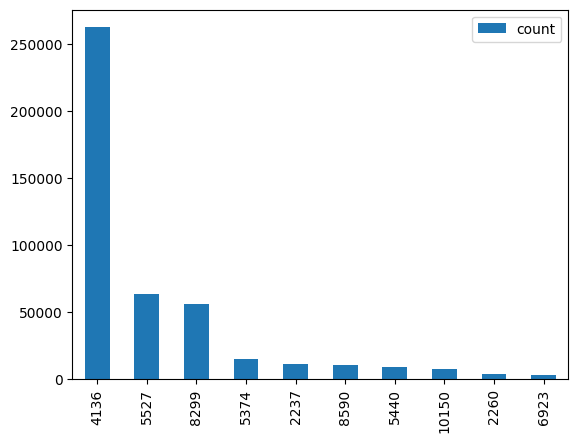

In [26]:
# Count method id
def get_text_signature(method_id):
  method = method_id.to_string(index=False)
  if method == '0x3593564c':
    return 'swap'
  else:
    return ''

df_methods = df.groupby(['method_id'])['method_id'] \
  .count() \
  .reset_index(name='count') \
  .sort_values(['count'], ascending=False) \
  .head(10)

df_methods = df_methods.assign(text_signature = lambda x: get_text_signature(x['method_id']))

print(df_methods)
df_methods.plot(kind='bar')

In [47]:
# Format block time
columns = [
  'block_time',
  'hash',
  'project',
  'token_bought_symbol',
  'token_sold_symbol',
  'token_bought_amount',
  'token_sold_amount',
  'amount_usd'
]
df_with_floor_time_by_hour = df.loc[:, columns]
df_with_floor_time_by_hour['block_time'] = pd \
  .to_datetime(df_with_floor_time_by_hour['block_time']) \
  .dt.floor('H') \
  .dt.strftime('%Y-%m-%d %H:%M:%S')

df_with_floor_time_by_day = df_with_floor_time_by_hour.loc[:]
df_with_floor_time_by_day['block_time'] = pd \
  .to_datetime(df_with_floor_time_by_day['block_time']) \
  .dt.floor('D') \
  .dt.strftime('%Y-%m-%d')

df_with_floor_time_by_day.head()

,block_time,hash,project,token_bought_symbol,token_sold_symbol,token_bought_amount,token_sold_amount,amount_usd
0,2023-04-14,0x2afae7763487e60b893cb57803694810e6d3d136186a6de6719921afd7ca304a,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-14,0xb38bba8bf8f61029a31e027c37fbc1065db784a39501d456a05cc490db5b4578,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-14,0x273894b35d8c30d32e1ffa22ee6aa320cc9f55f2adbba0583594ed47c031f6f6,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-14,0xc3760b499850b19d8f266dc10349d70f69c91698233697cbad2ee90ff957ed17,uniswap-2,PEPE,WETH,1.951464e+11,0.001,2.079390
4,2023-04-14,0x08153c0546e4f73b178edae90d1e30fb519c7c49ff0dcd00e4b0bcd74dab468c,uniswap-2,PEPE,WETH,2.519324e+12,0.013,27.131592


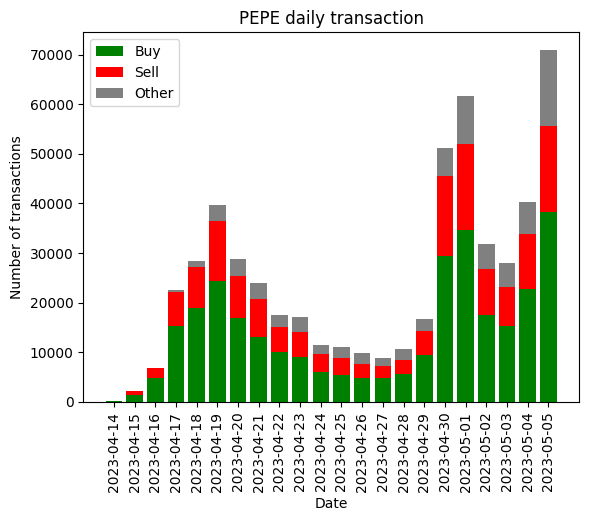

In [104]:
# Daily transaction
def get_other_count(row):
  return row['total_tx_count'] - row['tx_buy_count'] - row['tx_sell_count']

df_tx = df_with_floor_time_by_day.drop_duplicates(['hash'])
df_tx_count = df_tx \
  .groupby('block_time')['hash'] \
  .count() \
  .reset_index(name='total_tx_count')

df_swap_only = df_tx[df_tx['project'].notna()]
df_buy_count = df_swap_only \
  .groupby('block_time')['token_bought_symbol'] \
  .apply(lambda x: (x == 'PEPE').sum()) \
  .reset_index(name='tx_buy_count')

df_sell_count = df_swap_only \
  .groupby('block_time')['token_sold_symbol'] \
  .apply(lambda x: (x == 'PEPE').sum()) \
  .reset_index(name='tx_sell_count')

df_counter = df_tx_count.merge(
  df_buy_count.merge(df_sell_count, how='inner', on='block_time'),
  how='inner',
  on='block_time'
)

df_counter = df_counter.assign(tx_other_count = lambda x: get_other_count(x))

# Draw bar chart
_, ax = plt.subplots()
ax.bar(df_counter['block_time'], df_counter['tx_buy_count'], color='g')
ax.bar(df_counter['block_time'], df_counter['tx_sell_count'], bottom=df_counter['tx_buy_count'], color='r')
ax.bar(df_counter['block_time'], df_counter['tx_other_count'], bottom=df_counter['tx_buy_count'] + df_counter['tx_sell_count'], color='gray')

ax.set_xlabel('Date')
ax.set_ylabel('Number of transactions')
ax.set_title('PEPE daily transaction')
ax.legend(['Buy', 'Sell', 'Other'])

plt.xticks(rotation=90)

plt.show()

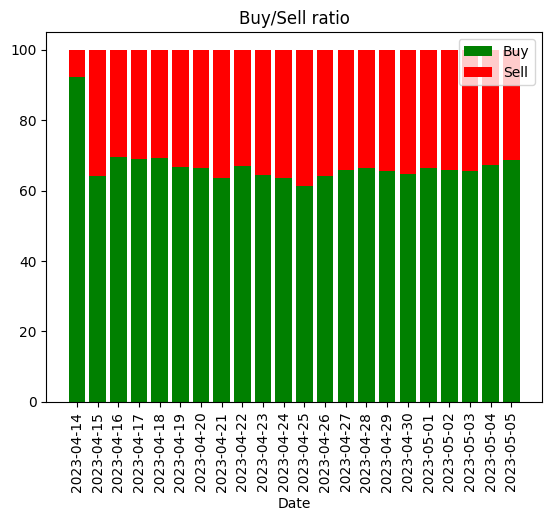

In [125]:
# Ratio of buy and sell
def get_buy_percentage(row):
  return round((row['tx_buy_count'] / (row['tx_buy_count'] + row['tx_sell_count'])) * 100, 2)

df_swap_ratio = df_counter[['block_time', 'tx_buy_count', 'tx_sell_count']]
df_swap_ratio = df_swap_ratio.assign(buy_percentage = lambda x: get_buy_percentage(x))
df_swap_ratio = df_swap_ratio.assign(sell_percentage = lambda x: 100 - x['buy_percentage'])

_, ax = plt.subplots()
ax.bar(df_swap_ratio['block_time'], df_swap_ratio['buy_percentage'], color='g')
ax.bar(df_swap_ratio['block_time'], df_swap_ratio['sell_percentage'], bottom=df_swap_ratio['buy_percentage'], color='r')

ax.set_xlabel('Date')
ax.set_title('Buy/Sell ratio')
ax.legend(['Buy', 'Sell'])

plt.xticks(rotation=90)
plt.show()



Number of transactions: 539,497 transactions
Number of swap transactions: 462,879 transactions
Swap ratio: 85.8%


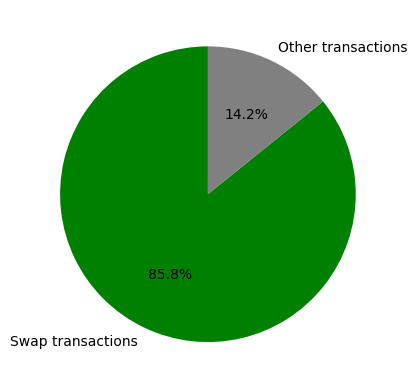

In [154]:
# Swap rate
df_unique_hash = df.drop_duplicates(['hash'])
number_of_txs = len(df_unique_hash)
number_of_swap_txs = len(df_unique_hash[df_unique_hash['project'].notna()])

swap_rate = round((number_of_swap_txs / number_of_txs) * 100, 2)

print('Number of transactions: {:,} transactions'.format(number_of_txs))
print('Number of swap transactions: {:,} transactions'.format(number_of_swap_txs))
print('Swap ratio: {}%'.format(swap_rate))

plt.pie(
  [swap_rate, 100 - swap_rate],
  labels=['Swap transactions', 'Other transactions'],
  colors=['green', 'gray'],
  startangle = 90,
  autopct='%1.1f%%'
)
plt.show()

Text(1, 40, 'ROI 380,959x')

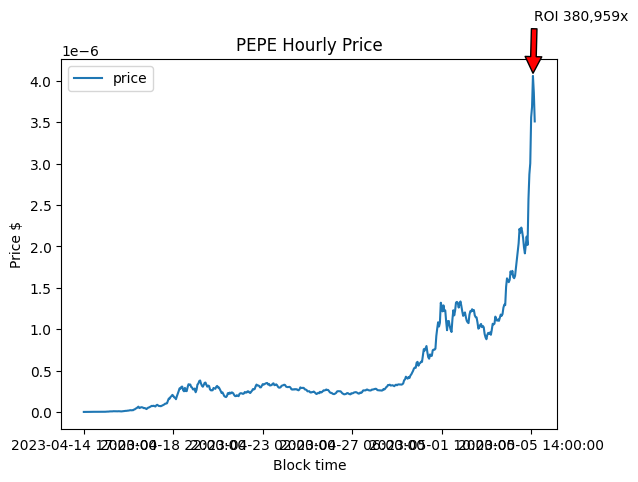

In [48]:
# Hourly price
df_price = df_with_floor_time_by_hour[df_with_floor_time_by_hour['project'].notna()] \
  .assign(price = lambda x:
    x['amount_usd'] / df.apply(
    lambda x: x['token_bought_amount']
      if x['token_bought_symbol'] == 'PEPE'
      else x['token_sold_amount']
    , axis=1
))

df_price = df_price.groupby('block_time')['price'].mean().reset_index()

init_price = df_price['price'].iloc[0]
highest_price = max(df_price['price'])
highest_price_index = df_price['price'].idxmax()
roi = round(highest_price / init_price)

# Draw figure
fig_price = df_price.plot(
  kind='line',
  title='PEPE Hourly Price',
  x='block_time',
  y='price',
  xlabel='Block time',
  ylabel='Price $'
)
fig_price.annotate(
  'ROI {:,}x'.format(roi),
  xy=(highest_price_index, highest_price),
  xycoords='data',
  xytext=(1, 40),
  textcoords='offset points',
  arrowprops=dict(facecolor='red', shrink=0.05),
)
